# Market Basket

Market Basket Analysis is a analysis technique which identifies the strength of association between pairs of products purchased together and identify patterns of co-occurrence.

The most commonly cited example of market basket analysis is the so-called “beer and diapers” case. The basic story is that a large retailer was able to mine their transaction data and find an unexpected purchase pattern of individuals that were buying beer and baby diapers at the same time.

The aim of the project is to make an analysis of the purchase data from Germany and France from the data set from the UCI Machine Learning Repository that represents transactional data from a UK retailer from 2010-2011.

## Importing libraries

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import datetime
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import warnings
warnings.filterwarnings('ignore')

## Configure Matplotlib

In [2]:
matplotlib.style.use('ggplot')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
matplotlib.rcParams['figure.figsize'] = 15, 6
plt.style.use('fivethirtyeight')

## Load data

In [3]:
df_retail = pd.read_excel("http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx")
# Variables
print("Online Retail dataset has {} data points with {} variables each.".format(*df_retail.shape))

Online Retail dataset has 541909 data points with 8 variables each.


## Data description

This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

The Online Retail data frame has 541909 rows and 8 columns.

This data frame contains the following columns:

InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.

StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.

Description: Product (item) name. Nominal.

Quantity: The quantities of each product (item) per transaction. Numeric.

InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.

UnitPrice: Unit price. Numeric, Product price per unit in sterling.

CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.

Country: Country name. Nominal, the name of the country where each customer resides.

## Explore data

In [4]:
df_retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
# data types of columns
df_retail.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [6]:
# Check missing value
df_retail.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

## Top ten country's customer

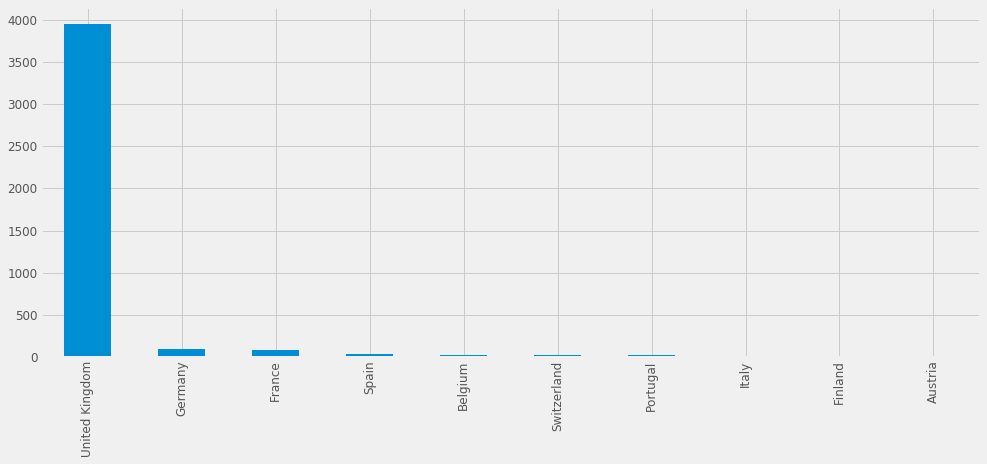

In [7]:
filtered_data=df_retail[['Country','CustomerID']].drop_duplicates()
filtered_data.Country.value_counts()[:10].plot(kind='bar')

## For this project we will unite the two countries that sell the most, excluding UK

In [8]:
df_retail_gm_fr=df_retail[(df_retail.Country=='Germany') | (df_retail.Country=='France')]
df_retail_gm_fr.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
26,536370,22728,ALARM CLOCK BAKELIKE PINK,24,2010-12-01 08:45:00,3.75,12583.0,France
27,536370,22727,ALARM CLOCK BAKELIKE RED,24,2010-12-01 08:45:00,3.75,12583.0,France
28,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,2010-12-01 08:45:00,3.75,12583.0,France
29,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,2010-12-01 08:45:00,0.85,12583.0,France
30,536370,21883,STARS GIFT TAPE,24,2010-12-01 08:45:00,0.65,12583.0,France


## Top selling products

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

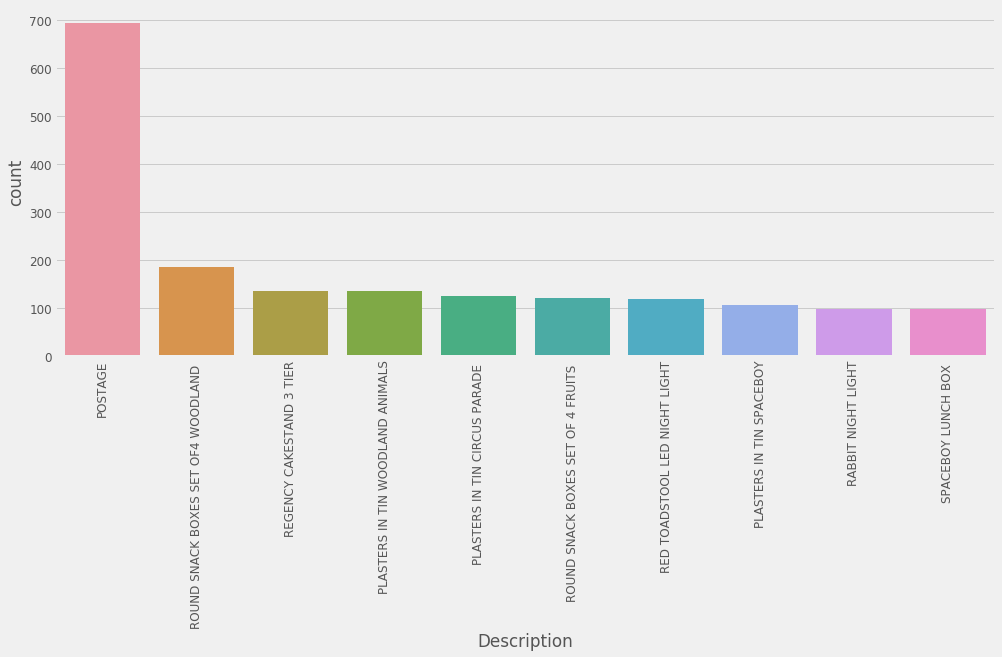

In [9]:
sns.countplot(x = 'Description', data = df_retail_gm_fr, order = df_retail_gm_fr['Description'].value_counts().iloc[:10].index)
plt.xticks(rotation=90)

## Prepare Dataset for Modeling

In [10]:
#Removing extra spaces
df_retail_gm_fr['Description'] = df_retail_gm_fr['Description'].str.strip()

In [11]:
# Removing duplicates
df_retail_gm_fr.dropna(axis=0, subset=['InvoiceNo'], inplace=True)

In [12]:
# Converting the invoice number to a string value
df_retail_gm_fr['InvoiceNo'] = df_retail_gm_fr['InvoiceNo'].astype('str')

In [13]:
# Removing the credit transactions
df_retail_gm_fr = df_retail_gm_fr[~df_retail_gm_fr['InvoiceNo'].str.contains('C')]

## Grouping the data

In [14]:
df_basket = (df_retail_gm_fr.groupby(['InvoiceNo', 'Description'])
             ['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo'))
df_basket.head()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 EGG HOUSE PAINTED WOOD,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,...,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC BOX SIGN HOME,ZINC FOLKART SLEIGH BELLS,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536861,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## There are many zeros in the data, but we also need to make sure that all positive values are converted to 1 and any value less than 0 is set to 0.

In [15]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

df_basket_sets = df_basket.applymap(encode_units)
df_basket_sets.drop('POSTAGE', inplace=True, axis=1)

## We will create frequent item sets with a minimum of 7%

In [16]:
df_frequent_itemsets = apriori(df_basket_sets, min_support=0.07, use_colnames=True)
df_frequent_itemsets.head()

,support,itemsets
0,0.084806,(ALARM CLOCK BAKELIKE PINK)
1,0.074205,(JAM MAKING SET PRINTED)
2,0.087161,(JUMBO BAG RED RETROSPOT)
3,0.089517,(JUMBO BAG WOODLAND ANIMALS)
4,0.090695,(LUNCH BAG APPLE DESIGN)


## In this step we will generate the rules with their corresponding support, confidence and elevation:

In [17]:
df_rules = association_rules(df_frequent_itemsets, metric="lift", min_threshold=1)
df_rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(PLASTERS IN TIN WOODLAND ANIMALS),(PLASTERS IN TIN CIRCUS PARADE),0.153121,0.140165,0.083628,0.546154,3.896509,0.062166,1.894552
1,(PLASTERS IN TIN CIRCUS PARADE),(PLASTERS IN TIN WOODLAND ANIMALS),0.140165,0.153121,0.083628,0.596639,3.896509,0.062166,2.099553
2,(PLASTERS IN TIN WOODLAND ANIMALS),(PLASTERS IN TIN SPACEBOY),0.153121,0.121319,0.081272,0.530769,4.374981,0.062696,1.872598
3,(PLASTERS IN TIN SPACEBOY),(PLASTERS IN TIN WOODLAND ANIMALS),0.121319,0.153121,0.081272,0.669903,4.374981,0.062696,2.565544
4,(ROUND SNACK BOXES SET OF 4 FRUITS),(ROUND SNACK BOXES SET OF4 WOODLAND),0.134276,0.204947,0.100118,0.745614,3.638082,0.072598,3.125381


## Let's filter for a large lift (3) and high confidence (0.5)

In [18]:
df_rules = df_rules[(df_rules['lift'] >= 3) & (df_rules['confidence'] >= 0.5)]
df_rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(PLASTERS IN TIN WOODLAND ANIMALS),(PLASTERS IN TIN CIRCUS PARADE),0.153121,0.140165,0.083628,0.546154,3.896509,0.062166,1.894552
1,(PLASTERS IN TIN CIRCUS PARADE),(PLASTERS IN TIN WOODLAND ANIMALS),0.140165,0.153121,0.083628,0.596639,3.896509,0.062166,2.099553
2,(PLASTERS IN TIN WOODLAND ANIMALS),(PLASTERS IN TIN SPACEBOY),0.153121,0.121319,0.081272,0.530769,4.374981,0.062696,1.872598
3,(PLASTERS IN TIN SPACEBOY),(PLASTERS IN TIN WOODLAND ANIMALS),0.121319,0.153121,0.081272,0.669903,4.374981,0.062696,2.565544
4,(ROUND SNACK BOXES SET OF 4 FRUITS),(ROUND SNACK BOXES SET OF4 WOODLAND),0.134276,0.204947,0.100118,0.745614,3.638082,0.072598,3.125381


## Visualizing results

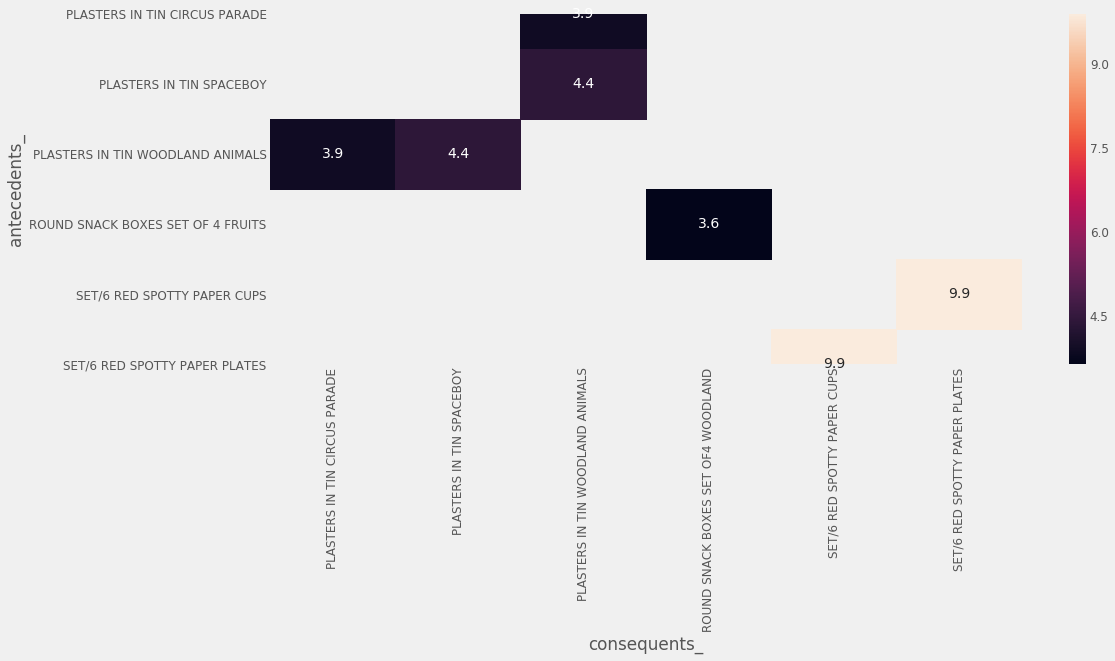

In [19]:
# Replacing the sets with strings
df_rules['antecedents_'] = df_rules['antecedents'].apply(lambda a: ','.join(list(a)))
df_rules['consequents_'] = df_rules['consequents'].apply(lambda a: ','.join(list(a)))

# Transforming the dataframe of rules into a matrix using the lift metric
pivot = df_rules.pivot(index = 'antecedents_',columns = 'consequents_', values= 'lift')

# Heatmap
sns.heatmap(pivot, annot = True)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

## Visualizing metrics

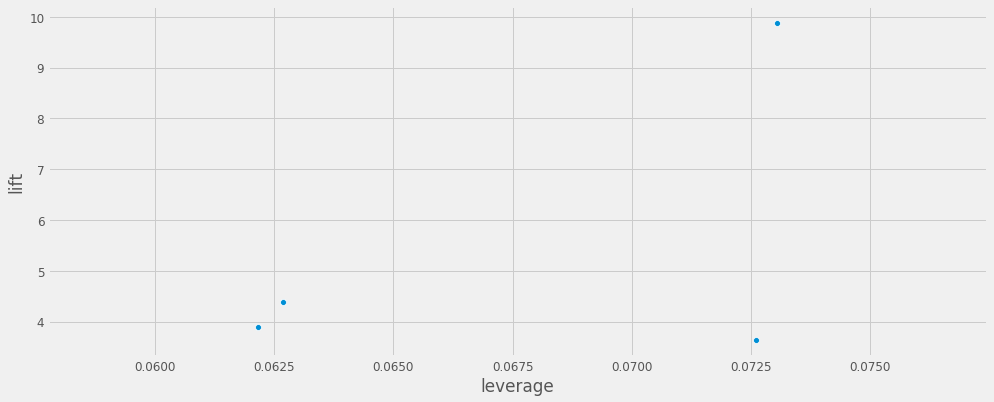

In [20]:
sns.scatterplot(x="leverage", y="lift", data=df_rules)